In [ ]:
# ------------------------------------------------------------------------------------------------------ #
#    PROCESSING PIPELINE FOR FIBER PHOTOMETRY RECORDINGS FROM THE DRINKING IN THE DARK (DID) PARADIGM    #
#                                - PLEIL LAB, WEILL CORNELL MEDICINE -                                   #
# ------------------------------------------------------------------------------------------------------ #
#
# Last updated: 10/08/2024
#  
# The pipeline:
#  1 - Code modules installation and import
#  2 - Data upload
#  3 - Selection of epocs and data
#  4 - Data filtering 1 (Median filter)
#  5 - Data filtering 2 (Low-pass filter)
#  6 - Downsampling
#  7 - Signal correction
#  8 - Normalization
#  9 - Behavior detection
# 10 - Traces export
# 11 - Processing details export

In [1]:
# --------------------------------------------
# - 1 - CODE MODULES INSTALLATION AND IMPORT -
# --------------------------------------------

!pip install tdt
!pip install pyexcel
!pip install pyexcel-xlsx
!pip install pandas openpyxl

import tdt
import numpy as np
import pandas as pd
import math
import datetime
import pylab as plt
from numpy.polynomial import Polynomial
from scipy import signal
from scipy.signal import medfilt, butter, filtfilt
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -------------------
# - 2 - DATA UPLOAD -
# -------------------

path = '/Users/Public/Desktop/...' # path to the data folder   
prefix = "XY11" # animal ID                                    

SIG = '_465C' # signal recording channel
ISO = '_405C' # iso control recording channel
TTL0 = 'PC3_' # TTL channel with epocs delimitation data
TTL1 = 'PC1_' # TTL channel with behavior data

cut = 0 # cutoff from the beginning of the recording (in seconds)          
dur = 20000 # duration of the recording (in seconds)   

# Uploads of the raw fiber data
data0 = tdt.read_block(path)

# Sets the end of the first TTL0 pulse as the beginning of the trace
First_TTL_Onset = data0.epocs[TTL0].onset[0]

# Shortens the fiber trace based on the times set above
data = tdt.read_block(path,t1 = First_TTL_Onset+cut,t2 = First_TTL_Onset+dur)

# Loads all on and off instances of the TTL0 and TTL1 pulses
TTL0_on_raw = data.epocs[TTL0].onset # TTL0 on
TTL0_off_raw = data.epocs[TTL0].offset # TTL0 off
TTL1_on_raw = data.epocs[TTL1].onset # TTL1 on
TTL1_off_raw = data.epocs[TTL1].offset # TTL1 off

# Loads recording sampling rates
sampling_rate = data.streams[SIG].fs

# Sampling rates checkpoint - sampling rates of all datasets must be identical
print("---------------------------------------------")
print('>>>>> Checkpoint - Required and Current sampling rates must be identical')
print()
print("Required sampling rate: 1017.2526245117188")
print(f"Current sampling rate:  " + str(sampling_rate))

sampling_rates = {"SIG": data.streams[SIG].fs, "ISO": data.streams[ISO].fs}
reference_value = data.streams[SIG].fs

if all(x == reference_value for x in sampling_rates.values()):
    print("---------------------------------------------")
    print("  ✓✓✓ Sampling rates are identical. ✓✓✓")
else:
    for key, rate in sampling_rates.items():
        if rate != reference_value:
            print()
            print(f"  !!!!! Different sampling rate found: {key}, size: {rate}, should be: " + str(reference_value) + " !!!!!")

# Aligns all datasets to the new timeline
time = np.linspace(0, len(data.streams[SIG].data)/sampling_rate, len(data.streams[SIG].data))

# Loads the first 10 'onset' values from both TTL channels of the raw trace
first_10_onsets0 = data0.epocs[TTL0].onset[:10]
first_10_offsets0 = data0.epocs[TTL0].offset[:10]
first_10_onsets1 = data0.epocs[TTL1].onset[:10]
first_10_offsets1 = data0.epocs[TTL1].offset[:10]

# Loads first 10 'onset' values from both TTL channels of the shortened trace
first_10_onsets00 = data.epocs[TTL0].onset[:10]
first_10_offsets00 = data.epocs[TTL0].offset[:10]
first_10_onsets11 = data.epocs[TTL1].onset[:10]
first_10_offsets11 = data.epocs[TTL1].offset[:10]

# Prints the first 10 values of the TTL channels from above for comparison
print("---------------------------------------------")
print('>>>>> Checkpoint')
print()
print(f"First onsets of raw TTL0:  " + str(first_10_onsets0))
print(f"First offsets of raw TTL0: " + str(first_10_offsets0))
print()
print(f"First onsets of cut TTL0:  " + str(first_10_onsets00))
print(f"First offsets of cut TTL0: " + str(first_10_offsets00))
print("---------------------------------------------")
print('>>>>> Checkpoint')
print()
print(f"First onsets raw TTL1:  " + str(first_10_onsets1))
print(f"First offsets raw TTL1: " + str(first_10_offsets1))
print()
print(f"First onsets raw TTL1:  " + str(first_10_onsets11))
print(f"First offsets raw TTL1: " + str(first_10_offsets11))

# Checkpoint of the length of all datasets 
data_sizes = {"SIG": len(data.streams[SIG].data), "ISO": len(data.streams[ISO].data), "time": len(time)}
data_reference_value = len(data.streams[SIG].data)

print("---------------------------------------------")
if all(x == data_reference_value for x in data_sizes.values()):
    print("  ✓✓✓ Identical dataset sizes: " + str(len(data.streams[SIG].data)) + " ✓✓✓")
else:
    for key, rate in data_sizes.items():
        if rate != data_reference_value:
            print(f"  !!!!! Different size of dataset found: {key}, size: {rate}, other values: " + str(data_reference_value) + " !!!!!")

# Dataset length correction - if there is a discrepancy in length of the datasets, longer traces are truncated
min_len = min(len(time), len(data.streams[SIG].data), len(data.streams[ISO].data))
time = time[:min_len]
sig = data.streams[SIG].data[:min_len]
iso = data.streams[ISO].data[:min_len]

# Checkpoint of the length of all datasets to confirm the correction was successful
data_sizes2 = {"SIG": len(sig), "ISO": len(iso), "time": len(time)}
data_reference_value2 = len(sig)

print("---------------------------------------------")
if all(x == data_reference_value2 for x in data_sizes2.values()):
    print("  ✓✓✓ Corrected dataset sizes: " + str(len(sig)) + " ✓✓✓")
else:
    for key, rate in data_sizes2.items():
        if rate != data_reference_value2:
            print(f"  !!!!! Different size of dataset: {key}, size: {rate}, other values: " + str(data_reference_value2) + " !!!!!")
print("---------------------------------------------")

Found Synapse note file: /Users/hiyoritakashima/Desktop/PUH/E2 BNST/20% EtOH DID/W2D1/#1\Notes.txt
read from t=0s to t=15148.92s
Found Synapse note file: /Users/hiyoritakashima/Desktop/PUH/E2 BNST/20% EtOH DID/W2D1/#1\Notes.txt
read from t=1249.93s to t=20249.93s
---------------------------------------------
>>>>> Checkpoint - Required and Current sampling rates must be identical

Required sampling rate: 1017.2526245117188
Current sampling rate:  1017.2526245117188
---------------------------------------------
  ✓✓✓ Sampling rates are identical. ✓✓✓
---------------------------------------------
>>>>> Checkpoint

First onsets of raw TTL0:  [  249.93366016  3890.22121984  4161.85499648 11165.83395328
 11409.44699392 15121.62574336]
First offsets of raw TTL0: [  250.9316096   3891.21916928  4162.85294592 11166.83190272
 11410.44494336 15122.6236928 ]

First onsets of cut TTL0:  [ 3890.22121984  4161.85499648 11165.83395328 11409.44699392
 15121.62574336]
First offsets of cut TTL0: [ 3891.

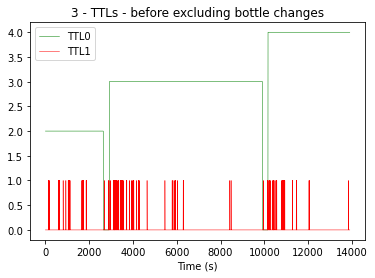

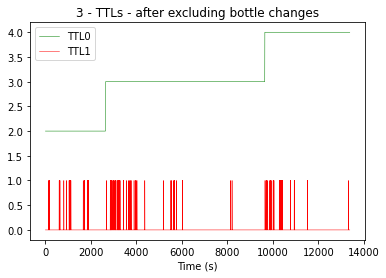

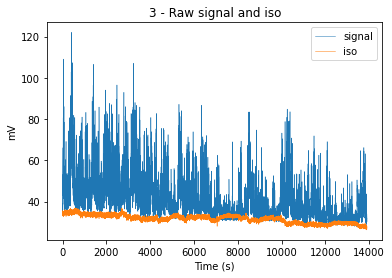

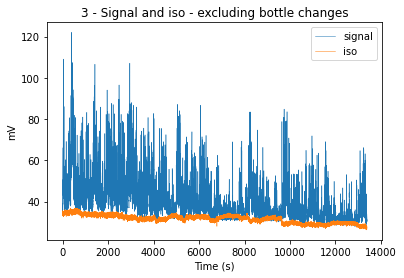

---------------------------------------------
>>>>> Checkpoint

old W1 start (s):  0.0
old W1 end (s):    2640.287304494743

old Et start (s):  2912.919699764658
old Et end (s):    9915.899423967167

old W2 start (s):  10160.512228695723
old W2 end (s):    13899.010589219788
---------------------------------------------
>>>>> Checkpoint

new W1 start (s):  0.0
new W1 end (s):    2640.287304494743

new Et start (s):  2640.2882875347927
new Et end (s):    9643.268011737302

new W2 start (s):  9643.268994777352
new W2 end (s):    13381.767355301416
---------------------------------------------


In [3]:
# -----------------------------------
# - 3 - SELECTION OF EPOCS AND DATA - 
# -----------------------------------

# TTLs to mark epocs and licks
TTL0_on_raw = data.epocs[TTL0].onset
TTL0_off_raw = data.epocs[TTL0].offset
TTL1_on_raw = data.epocs[TTL1].onset
TTL1_off_raw = data.epocs[TTL1].offset

TTL0_on = TTL0_on_raw - (First_TTL_Onset+cut)
TTL0_off = TTL0_off_raw - (First_TTL_Onset+cut)
TTL1_on = TTL1_on_raw - (First_TTL_Onset+cut)
TTL1_off = TTL1_off_raw - (First_TTL_Onset+cut)

TTL0_on_indices = np.searchsorted(time, TTL0_on)
TTL0_off_indices = np.searchsorted(time, TTL0_off)
TTL1_on_indices0 = np.searchsorted(time, TTL1_on)
TTL1_on_indices = TTL1_on_indices0[1:]
TTL1_off_indices0 = np.searchsorted(time, TTL1_off)
TTL1_off_indices = TTL1_off_indices0[:-1]

TTL0_array = np.zeros(len(time))
TTL1_array = np.zeros(len(time))
TTL1_array_starts = np.zeros(len(time))
TTL1_array_ends = np.zeros(len(time))

# Fills TTL0_array
for i in range(len(TTL0_on_indices)):
    end_idx1 = TTL0_on_indices[0]
    TTL0_array[:end_idx1] = 2

for i in range(len(TTL0_on_indices)):
    start_idx2 = TTL0_off_indices[1]
    end_idx2 = TTL0_on_indices[2]
    TTL0_array[start_idx2:end_idx2] = 3
    
for i in range(len(TTL0_on_indices)):
    start_idx3 = TTL0_off_indices[3]
    TTL0_array[start_idx3:] = 4
    
# Fills TTL1_array
for i in range(len(TTL1_on_indices)):
    start_idx = TTL1_off_indices[i]
    end_idx = TTL1_on_indices[i]
    TTL1_array[start_idx:end_idx] = 1
    
for i in range(len(TTL1_on_indices)):
    start_idx = TTL1_off_indices[i]
    TTL1_array_starts[start_idx] = 1  

for i in range(len(TTL1_on_indices)):
    start_idx = TTL1_on_indices[i]
    TTL1_array_ends[start_idx] = 1

# Plots epocs and licks before excluding bottle changes
plt.plot(time, TTL0_array, linewidth=0.5, color = 'green', label='TTL0')
plt.plot(time, TTL1_array, linewidth=0.5, color = 'red', label='TTL1')
plt.xlabel('Time (s)')
plt.title(prefix + ' - TTLs - before excluding bottle changes')
plt.legend()
plt.show()    

# Creates a master array combining all the datasets
master_array = pd.DataFrame({'time': time, 'sig': sig, 'iso': iso, 'TTL0': TTL0_array, 'TTL1': TTL1_array, 'TTL1_starts': TTL1_array_starts, 'TTL1_ends': TTL1_array_ends})

# Creates a mask to filter rows where TTL0 is not equal to 0
master_mask = (master_array['TTL0'] != 0)

# Finds the consecutive groups of True values in the mask
groups = (master_mask != master_mask.shift()).cumsum()

# Filters the 'master_array' based on the mask and consecutive groups
master_cut = master_array[master_mask]

# Master array re-exported into separate arrays after cutting
sig_cut = master_cut['sig'].to_numpy()
iso_cut = master_cut['iso'].to_numpy()
TTL0_cut = master_cut['TTL0'].to_numpy()
TTL1_cut = master_cut['TTL1'].to_numpy()
TTL1_starts_cut = master_cut['TTL1_starts'].to_numpy()
TTL1_ends_cut = master_cut['TTL1_ends'].to_numpy()
TTL1_starts_cut_neg = TTL1_starts_cut -1
TTL1_ends_cut_neg = TTL1_ends_cut -1

min_cut_len = len(sig_cut)
time_cut = time[:min_cut_len]

cut_master_array = pd.DataFrame({'time': time_cut, 'sig': sig_cut, 'iso': iso_cut, 'TTL0': TTL0_cut, 'TTL1': TTL1_cut, 'TTL1_starts': TTL1_starts_cut, 'TTL1_ends': TTL1_ends_cut})

# Plots epocs and licks after excluding bottle changes
plt.plot(time_cut, TTL0_cut, linewidth=0.5, color = 'green', label='TTL0')
plt.plot(time_cut, TTL1_cut, linewidth=0.5, color = 'red', label='TTL1')
plt.xlabel('Time (s)')
plt.title(prefix + ' - TTLs - after excluding bottle changes')
plt.legend()
plt.show()

plt.plot(time, sig, linewidth=0.5, label='signal')
plt.plot(time, iso, linewidth=0.5, label='iso')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title(prefix + ' - Raw signal and iso')
plt.legend()
plt.show()  

plt.plot(time_cut, sig_cut, linewidth=0.5, label='signal')
plt.plot(time_cut, iso_cut, linewidth=0.5, label='iso')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title(prefix + ' - Signal and iso - after excluding bottle changes')
plt.legend()
plt.show()    

# Determining timestamps of starts and ends of epocs from the array before excluding the bottle changes

# Finds the first appearance of each value (2, 3, 4) in 'TTL0'
first_TTL0 = master_cut.groupby('TTL0')['time'].idxmin()

# Finds the last appearance of each value (2, 3, 4) in 'TTL0'
last_TTL0 = master_cut.groupby('TTL0')['time'].idxmax()

# Extracts the corresponding 'time' values
first_TTL0_time = master_cut.loc[first_TTL0]
last_TTL0_time = master_cut.loc[last_TTL0]

# Accessing the 'time' values that correspond to the first and last appearances of 2, 3, and 4 in 'TTL0'
first_TTL0_2 = first_TTL0_time[first_TTL0_time['TTL0'] == 2]['time'].values[0]
last_TTL0_2 = last_TTL0_time[last_TTL0_time['TTL0'] == 2]['time'].values[0]

first_TTL0_3 = first_TTL0_time[first_TTL0_time['TTL0'] == 3]['time'].values[0]
last_TTL0_3 = last_TTL0_time[last_TTL0_time['TTL0'] == 3]['time'].values[0]

first_TTL0_4 = first_TTL0_time[first_TTL0_time['TTL0'] == 4]['time'].values[0]
last_TTL0_4 = last_TTL0_time[last_TTL0_time['TTL0'] == 4]['time'].values[0]

print("---------------------------------------------")
print('>>>>> Checkpoint')
print()
print('old W1 start (s): ', first_TTL0_2)
print('old W1 end (s):   ', last_TTL0_2)
print()
print('old Et start (s): ', first_TTL0_3)
print('old Et end (s):   ', last_TTL0_3)
print()
print('old W2 start (s): ', first_TTL0_4)
print('old W2 end (s):   ', last_TTL0_4)
print("---------------------------------------------")

# Determining timestamps of starts and ends of epocs from the array after excluding bottle changes

# Finds the first appearance of each value (2, 3, 4) in 'TTL0'
first_TTL0_cut = cut_master_array.groupby('TTL0')['time'].idxmin()

# Finds the last appearance of each value (2, 3, 4) in 'TTL0'
last_TTL0_cut = cut_master_array.groupby('TTL0')['time'].idxmax()

# Extracts the corresponding 'time' values
first_TTL0_time_cut = cut_master_array.loc[first_TTL0_cut]
last_TTL0_time_cut = cut_master_array.loc[last_TTL0_cut]

# Accessing the 'time' values that correspond to the first and last appearances of 2, 3, and 4 in 'TTL0'
first_TTL0_2_cut = first_TTL0_time_cut[first_TTL0_time_cut['TTL0'] == 2]['time'].values[0]
last_TTL0_2_cut = last_TTL0_time_cut[last_TTL0_time_cut['TTL0'] == 2]['time'].values[0]

first_TTL0_3_cut = first_TTL0_time_cut[first_TTL0_time_cut['TTL0'] == 3]['time'].values[0]
last_TTL0_3_cut = last_TTL0_time_cut[last_TTL0_time_cut['TTL0'] == 3]['time'].values[0]

first_TTL0_4_cut = first_TTL0_time_cut[first_TTL0_time_cut['TTL0'] == 4]['time'].values[0]
last_TTL0_4_cut = last_TTL0_time_cut[last_TTL0_time_cut['TTL0'] == 4]['time'].values[0]

print('>>>>> Checkpoint')
print()
print('new W1 start (s): ', first_TTL0_2_cut)
print('new W1 end (s):   ', last_TTL0_2_cut)
print()
print('new Et start (s): ', first_TTL0_3_cut)
print('new Et end (s):   ', last_TTL0_3_cut)
print()
print('new W2 start (s): ', first_TTL0_4_cut)
print('new W2 end (s):   ', last_TTL0_4_cut)
print("---------------------------------------------")

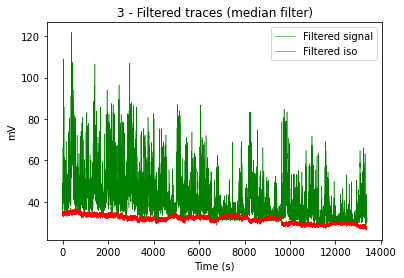

In [4]:
# ------------------------
# - 4 - DATA FILTERING 1 - Median filtering to remove large electrical artifacts
# ------------------------

# Size of median filter kernel
medlift_kernelsize = 101

# Applies a median filter to the signal and control channels
P1_465Ad = medfilt(sig_cut, kernel_size=medlift_kernelsize)
P1_405Ad = medfilt(iso_cut, kernel_size=medlift_kernelsize)

# Plots the filtered signal and iso traces
plt.plot(time_cut, P1_465Ad, 'g', linewidth=0.5, label='Filtered signal')
plt.plot(time_cut, P1_405Ad, 'r', linewidth=0.5, label='Filtered iso')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title(prefix + ' - Filtered traces (median filter)')
plt.legend()
plt.show()

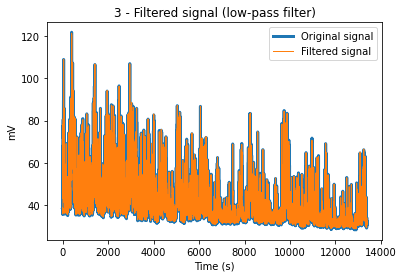

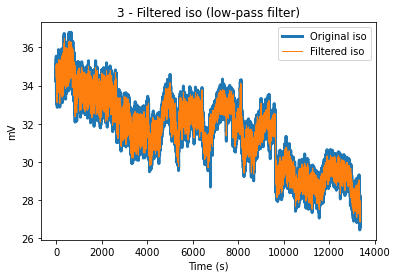

In [7]:
# ------------------------
# - 5 - DATA FILTERING 2 - Low-pass filter to remove high-frequency noise and artifacts
# ------------------------

# Defines a low-pass filter and its cutoff frequency
fs = sampling_rate # fs = sampling frequency
f_cutoff = 2 # only frequencies lower than this value will pass
nyq = 0.5 * fs # 'Nyquist frequency' - used to normalize the cutoff frequency for the filter
f_cutoff_norm = f_cutoff / nyq # calculates the normalized cutoff frequency

# Smoothing of the signal trace using Butterworth low-pass filter
x = P1_465Ad # assigns the signal channel to 'x'
b, a = signal.butter(3, f_cutoff_norm, btype='low') # calculates a and b coeficients needed for filtering
filtered_signal = signal.filtfilt(b, a, x) # filters the signal trace by a zero-phase forward and reverse filtering

# Plots the original and filtered signal traces
plt.plot(time_cut, x, linewidth=3, label='Original signal')
plt.plot(time_cut, filtered_signal,linewidth=1, label='Filtered signal')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title(prefix + ' - Filtered signal (low-pass filter)')
plt.legend()
plt.show()

# Smoothing of the control trace using Butterworth low-pass filter
y = P1_405Ad # assigns the iso channel to 'y'
b, a = signal.butter(3, f_cutoff_norm, btype='low') # calculate a and b coeficients needed for filtering
filtered_control = signal.filtfilt(b, a, y) # filter the iso trace by a zero-phase forward and reverse filtering

# Plots the original and filtered control traces
plt.plot(time_cut, y, linewidth=3, label='Original iso')
plt.plot(time_cut, filtered_control, linewidth=1, label='Filtered iso')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title(prefix + ' - Filtered iso (low-pass filter)')
plt.legend()
plt.show()

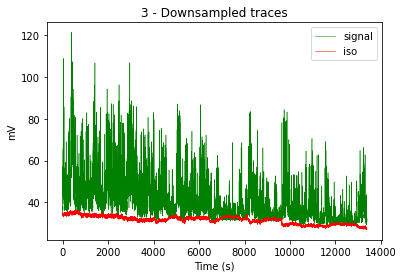

In [8]:
# --------------------
# - 6 - DOWNSAMPLING -
# --------------------

N = 100 # the number of consecutive samples to be averaged into a single value

P1_405d = []
P1_465d = []

# A moving window mean in steps of size N
for i in range(0, len(filtered_signal), N):
 P1_465d.append(np.mean(filtered_signal[i:i+N-1]))

for i in range(0, len(filtered_control), N):
 P1_405d.append(np.mean(filtered_control[i:i+N-1]))

# Decimates the time array to match the length of the downsampled signal and iso traces
P1_time2 = time_cut[::N] # goes from the beginning to the end of the time array in steps on N
P1_time2 = P1_time2[:len(P1_465d)] # truncates the new time array if it needs further correction

# Plots downsampled traces
plt.plot(P1_time2, P1_465d, 'g-', linewidth=0.5, label='signal')
plt.plot(P1_time2, P1_405d, 'r-', linewidth=0.5, label='iso')
plt.title(prefix + ' - Downsampled traces')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.legend()
plt.show()

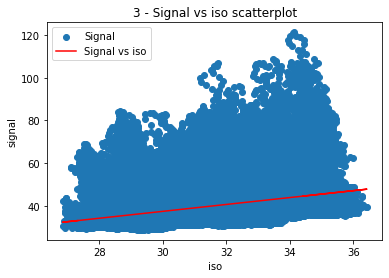

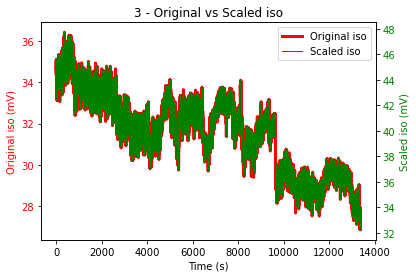

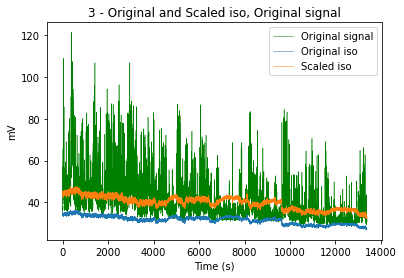

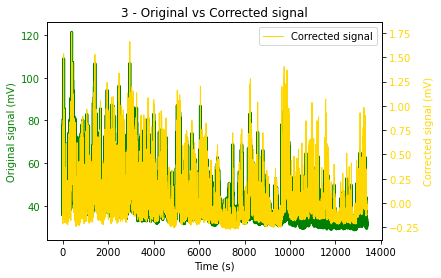

In [9]:
# -------------------------
# - 7 - SIGNAL CORRECTION - Photobleaching and motion correction of the signal using the control trace
# -------------------------

# Converts data arrays into NumPy arrays
P1_405np = np.array(P1_405d) 
P1_465np = np.array(P1_465d) 
                                                        
# Fits a first-degree polynomial (linear fit) between signal and iso
poly = Polynomial.fit(P1_405np, P1_465np, 1)
coefficients = poly.coef # extracts the the slope and intercept of the fitted polynomial equation

# Plots signal and iso traces, along with the fitted line                                                                               
plt.scatter(P1_405np, P1_465np, label = 'Signal')                                  
plt.plot(P1_405np, poly(P1_405np), 'r', label = 'Signal vs iso')                         
plt.title(prefix + " - Signal vs iso scatterplot")
plt.xlabel('iso')
plt.ylabel('signal')
plt.legend()
plt.show()

# Scales the iso trace based on the linear fit coefficients
scaled_control = poly(P1_405np) # polynomial to transform the iso based on the fitted relationship

# Plots a dual-axis plot to compare iso vs scaled iso
fig, ax1 = plt.subplots()

# The original iso trace on the left y-axis (in red)
ax1.plot(P1_time2, P1_405np, linewidth=3, label='Original iso', color='red')
ax1.set_ylabel('Original iso (mV)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Creates a second y-axis on the right side of the plot
ax2 = ax1.twinx()

# The scaled iso trace on the right y-axis (in green)
ax2.plot(P1_time2, scaled_control, linewidth=1, label='Scaled iso', color='green')
ax2.set_ylabel('Scaled iso (mV)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adds legend for all traces
ax1.set_xlabel('Time (s)')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
plt.title(prefix + ' - Original vs Scaled iso')
plt.show()

# Plots the iso channel before and after scaling with the original signal trace
plt.plot(P1_time2, P1_465np, 'g', linewidth=0.5, label='Original signal')
plt.plot(P1_time2, P1_405np, linewidth=0.5, label='Original iso')
plt.plot(P1_time2, scaled_control, linewidth=0.5, label='Scaled iso')
plt.ylabel("mV")
plt.xlabel("Time (s)")
plt.title(prefix + " - Original and Scaled iso, Original signal")
plt.legend()
plt.show()

# Final signal correction by scaled iso
P1_dff = (P1_465np - scaled_control) / scaled_control

# Plots the original and corrected signal traces
fig, ax1 = plt.subplots()

# The original signal trace on the left y-axis (in green)
ax1.plot(P1_time2, P1_465np, linewidth=3, label='Original signal', color='green')
ax1.set_ylabel('Original signal (mV)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creates a second y-axis on the right side of the plot
ax2 = ax1.twinx()

# The corrected signal trace on the right y-axis (in gold)
ax2.plot(P1_time2, P1_dff, linewidth=1, label='Corrected signal', color='gold')
ax2.set_ylabel('Corrected signal (mV)', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

# Adds legend for all traces
ax1.set_xlabel('Time (s)')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
plt.title(prefix + ' - Original vs Corrected signal')
plt.legend()
plt.show()

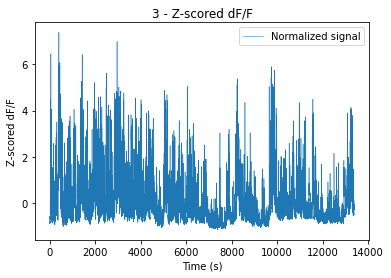

In [10]:
# ---------------------
# - 8 - NORMALIZATION - Z-scoring of the corrected signal trace
# ---------------------

P1_norm = P1_dff
mean = np.mean(P1_norm) # mean value of the whole signal trace
std = np.std(P1_norm) # standard deviation of the whole signal trace
P1_norm2 = (P1_norm - mean) / std # calculates the z-score of the signal

# Plots the normalized signal
plt.plot(P1_time2,P1_norm2,linewidth=0.5, label = 'Normalized signal')
plt.title(prefix + ' - Z-scored dF/F')
plt.xlabel('Time (s)')
plt.ylabel('zdF/F')
plt.legend()
plt.show()

---------------------------------------------
>>>>> Checkpoint - All dataset lengths must be identical.

All epocs total length (rows of data) :       136127
All epocs time total length (rows of data) :  136127
Both numbers above must be equal to:          136127

  ✓✓✓ All datasets lenghts are identical. ✓✓✓

---------------------------------------------
>>>>> Checkpoint - Counts of licks and bouts in each epoc.

Water1 bouts:  19
Water1 licks:  11

Alcohol bouts:  26
Alcohol licks:  27

Water2 bouts:  29
Water2 licks:  10

---------------------------------------------


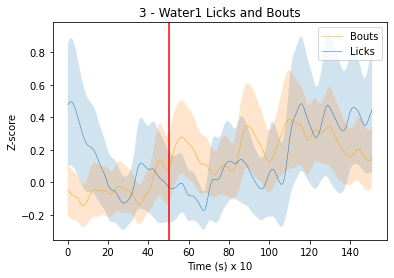

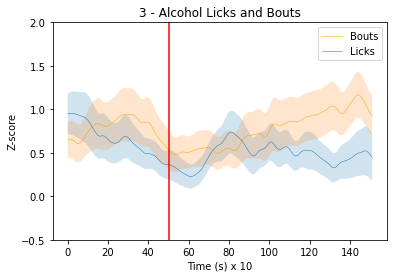

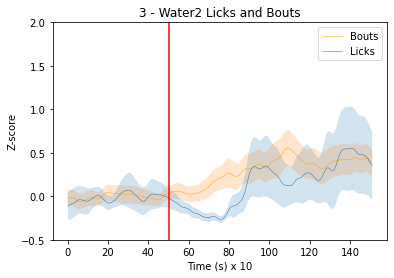

---------------------------------------------

 ✓ Data have been successfully exported to: 3 - pre-post - licks and bouts - no overlaps.xlsx

 ✓ Data have been successfully exported to: 3 - during licking.xlsx

 ✓ Data have been successfully exported to: 3 - pre-dur-post - no overlaps.xlsx
 ✓ Data have been successfully exported to: 3 - pre-post - with overlaps.xlsx
 ✓ Data have been successfully exported to: 3 - during - with overlaps - timestamps.xlsx

---------------------------------------------


In [16]:
# --------------------------
# - 9 - BEHAVIOR DETECTION - Division of the final trace into epocs and detection of licks and bouts of licks
# --------------------------

# Division of the final trace into epocs (Water1, Alcohol, Water2)

# Finds the indices in the time array corresponding to the epoc division points
cut_index_1 = np.argmax(P1_time2 >= last_TTL0_2_cut)
cut_index_2 = np.argmax(P1_time2 >= last_TTL0_3_cut)

# Creates sections in the signal trace and time based on the division points
W1 = P1_norm2[:cut_index_1]
Et = P1_norm2[cut_index_1:cut_index_2]
W2 = P1_norm2[cut_index_2:]

W1_t = P1_time2[:cut_index_1]
Et_t = P1_time2[cut_index_1:cut_index_2]
W2_t = P1_time2[cut_index_2:]

norm2_blocks_total = len(W1)+len(Et)+len(W2)
time2_blocks_total = len(W1_t)+len(Et_t)+len(W2_t)

# Checkpoint of correct epoc division
print("---------------------------------------------")
print('>>>>> Checkpoint - All dataset lengths must be identical.')
print()
print('All epocs total length (rows of data) :      ', norm2_blocks_total)
print('All epocs time total length (rows of data) : ', time2_blocks_total)
print('Both numbers above must be equal to:         ', len(P1_norm2))
print()

# Automatic check if lengths of the datasets are identical and correct
epocs_comparison = {"epocs_total_length": norm2_blocks_total, "epocs_total_time_length": time2_blocks_total}
reference_value = len(P1_norm2)

if all(x == reference_value for x in epocs_comparison.values()):
    print("  ✓✓✓ All datasets lenghts are identical. ✓✓✓")
else:
    for key, rate in epocs_comparison.items():
        if rate != reference_value:
            print(f"  !!!!! Different dataset lengths found: {key}, size: {rate}, should be: " + str(reference_value) + " !!!!!")
print("---------------------------------------------")

# Detection of behavior (individual licks and bouts of licks)

TTL1_starts_cut_t = cut_master_array[cut_master_array['TTL1_starts'] == 1]['time'].values.flatten()
TTL1_ends_cut_t = cut_master_array[cut_master_array['TTL1_ends'] == 1]['time'].values.flatten()
lick_times = TTL1_starts_cut_t
lick_times_ends = TTL1_ends_cut_t

# Defining criteria for licks and bouts
bout_threshold = 1 # maximal interval between two TTL onsets to be grouped in a bout (in seconds)
min_bout_duration = 0.5 # minimal bout duration(in seconds)
max_bout_duration = 60 # maximal bout duration (in seconds)
min_bout_size = 3 # minimal bout size (in rows of data; 1s = ~10 rows)
min_lick_size = 1 # minimal number of TTL pulses to be considered a lick (in rows of data; 1s = ~10 rows)

lick_bouts = []
isolated_licks = []

# Detection of licks and bouts
current_bout = [lick_times[0]]

for i in range(1, len(lick_times)):
    if lick_times[i] - lick_times[i-1] <= bout_threshold:
        current_bout.append(lick_times[i])
    else:
        bout_duration = current_bout[-1] - current_bout[0]
        bout_size = len(current_bout)
        if bout_duration <= max_bout_duration:
            if bout_size == min_lick_size:
                isolated_licks.append(current_bout)
            elif bout_duration >= min_bout_duration and bout_size >= min_bout_size:
                lick_bouts.append(current_bout)
            else:
                isolated_licks.append(current_bout)
        current_bout = [lick_times[i]]
        
# Separation of licks and bouts by epocs

# Setting the starts and ends of epocs
water1_start = first_TTL0_2_cut
water1_end = last_TTL0_2_cut
alcohol_start = first_TTL0_3_cut
alcohol_end = last_TTL0_3_cut
water2_start = first_TTL0_4_cut
water2_end = last_TTL0_4_cut

# Creates empty lists to store licks and bouts that occur within each epoc
water1_lick_bouts = []
water1_isolated_licks = []
alcohol_lick_bouts = []
alcohol_isolated_licks = []
water2_lick_bouts = []
water2_isolated_licks = []

# Loops through each bout and lick and checks which epoc they belong to
for bout in lick_bouts:
    if bout[0] >= alcohol_start and bout[-1] <= alcohol_end:
        alcohol_lick_bouts.append(bout)
    if bout[0] >= water1_start and bout[-1] <= water1_end:    
        water1_lick_bouts.append(bout)
    if bout[0] >= water2_start and bout[-1] <= water2_end:    
        water2_lick_bouts.append(bout)    

for bout in isolated_licks:
    if bout[0] >= alcohol_start and bout[-1] <= alcohol_end:
        alcohol_isolated_licks.append(bout)     
    if bout[0] >= water1_start and bout[-1] <= water1_end:    
        water1_isolated_licks.append(bout)
    if bout[0] >= water2_start and bout[-1] <= water2_end:    
        water2_isolated_licks.append(bout)    

# Prints the number of bouts and licks that occur within each epoc
print('>>>>> Checkpoint - Counts of licks and bouts in each epoc.')
print()
print('Water1 bouts: ', len(water1_lick_bouts))
print('Water1 licks: ', len(water1_isolated_licks))
print()
print('Alcohol bouts: ', len(alcohol_lick_bouts))
print('Alcohol licks: ', len(alcohol_isolated_licks))
print()
print('Water2 bouts: ', len(water2_lick_bouts))
print('Water2 licks: ', len(water2_isolated_licks))
print("---------------------------------------------")

# All TTL1 ON times
first_elements = []
for sub_array in water1_lick_bouts:
    if len(sub_array) > 0:
        first_elements.append(sub_array[0])

first_elements2 = []
for sub_array in alcohol_lick_bouts:
    if len(sub_array) > 0:
        first_elements2.append(sub_array[0])

first_elements3 = []
for sub_array in water2_lick_bouts:
    if len(sub_array) > 0:
        first_elements3.append(sub_array[0])

first_elements4 = []
for sub_array in water1_isolated_licks:
    if len(sub_array) > 0:
        first_elements4.append(sub_array[0])

first_elements5 = []
for sub_array in alcohol_isolated_licks:
    if len(sub_array) > 0:
        first_elements5.append(sub_array[0])

first_elements6 = []
for sub_array in water2_isolated_licks:
    if len(sub_array) > 0:
        first_elements6.append(sub_array[0])

W1_twos = np.full(len(first_elements), 2)
Et_twos = np.full(len(first_elements2), 2)
W2_twos = np.full(len(first_elements3), 2)
W1_ones = np.full(len(first_elements4), 1)
Et_ones = np.full(len(first_elements5), 1)
W2_ones = np.full(len(first_elements6), 1)

W1_all_on_times = np.concatenate((first_elements, first_elements4))
Et_all_on_times = np.concatenate((first_elements2, first_elements5))
W2_all_on_times = np.concatenate((first_elements3, first_elements6))

W1_all_on_types = np.concatenate((W1_twos, W1_ones))
Et_all_on_types = np.concatenate((Et_twos, Et_ones))
W2_all_on_types = np.concatenate((W2_twos, W2_ones))

W1_all_on_times_a = pd.DataFrame(W1_all_on_times, columns=['times'])
Et_all_on_times_a = pd.DataFrame(Et_all_on_times, columns=['times'])
W2_all_on_times_a = pd.DataFrame(W2_all_on_times, columns=['times'])

W1_all_on_types_a = pd.DataFrame(W1_all_on_types, columns=['type'])
Et_all_on_types_a = pd.DataFrame(Et_all_on_types, columns=['type'])
W2_all_on_types_a = pd.DataFrame(W2_all_on_types, columns=['type'])

W1_all_on_times_f = pd.concat([W1_all_on_times_a, W1_all_on_types_a], axis=1)
Et_all_on_times_f = pd.concat([Et_all_on_times_a, Et_all_on_types_a], axis=1)
W2_all_on_times_f = pd.concat([W2_all_on_times_a, W2_all_on_types_a], axis=1)

W1_all_on_times_f_s = W1_all_on_times_f.sort_values(by=W1_all_on_times_f.columns[0], axis=0)
Et_all_on_times_f_s = Et_all_on_times_f.sort_values(by=Et_all_on_times_f.columns[0], axis=0)
W2_all_on_times_f_s = W2_all_on_times_f.sort_values(by=W2_all_on_times_f.columns[0], axis=0)

W1_all_on_times_f_s = W1_all_on_times_f_s.reset_index(drop=True)
Et_all_on_times_f_s = Et_all_on_times_f_s.reset_index(drop=True)
W2_all_on_times_f_s = W2_all_on_times_f_s.reset_index(drop=True)

# All TTL1 OFF times 
last_elements = []
for sub_array in water1_lick_bouts:
    if len(sub_array) > 0:
        last_elements.append(sub_array[-1])

last_elements2 = []
for sub_array in alcohol_lick_bouts:
    if len(sub_array) > 0:
        last_elements2.append(sub_array[-1])

last_elements3 = []
for sub_array in water2_lick_bouts:
    if len(sub_array) > 0:
        last_elements3.append(sub_array[-1])

last_elements4 = []
for sub_array in water1_isolated_licks:
    if len(sub_array) > 0:
        last_elements4.append(sub_array[-1])

last_elements5 = []
for sub_array in alcohol_isolated_licks:
    if len(sub_array) > 0:
        last_elements5.append(sub_array[-1])

last_elements6 = []
for sub_array in water2_isolated_licks:
    if len(sub_array) > 0:
        last_elements6.append(sub_array[-1])

W1_twos2 = np.full(len(last_elements), 2)
Et_twos2 = np.full(len(last_elements2), 2)
W2_twos2 = np.full(len(last_elements3), 2)
W1_ones2 = np.full(len(last_elements4), 1)
Et_ones2 = np.full(len(last_elements5), 1)
W2_ones2 = np.full(len(last_elements6), 1)

W1_all_off_times = np.concatenate((last_elements, last_elements4))
Et_all_off_times = np.concatenate((last_elements2, last_elements5))
W2_all_off_times = np.concatenate((last_elements3, last_elements6))

W1_all_off_types = np.concatenate((W1_twos2, W1_ones2))
Et_all_off_types = np.concatenate((Et_twos2, Et_ones2))
W2_all_off_types = np.concatenate((W2_twos2, W2_ones2))

W1_all_off_times_a = pd.DataFrame(W1_all_off_times, columns=['times'])
Et_all_off_times_a = pd.DataFrame(Et_all_off_times, columns=['times'])
W2_all_off_times_a = pd.DataFrame(W2_all_off_times, columns=['times'])

W1_all_off_types_a = pd.DataFrame(W1_all_off_types, columns=['type'])
Et_all_off_types_a = pd.DataFrame(Et_all_off_types, columns=['type'])
W2_all_off_types_a = pd.DataFrame(W2_all_off_types, columns=['type'])

W1_all_off_times_f = pd.concat([W1_all_off_times_a, W1_all_off_types_a], axis=1)
Et_all_off_times_f = pd.concat([Et_all_off_times_a, Et_all_off_types_a], axis=1)
W2_all_off_times_f = pd.concat([W2_all_off_times_a, W2_all_off_types_a], axis=1)

W1_all_off_times_f_s = W1_all_off_times_f.sort_values(by=W1_all_off_times_f.columns[0], axis=0)
Et_all_off_times_f_s = Et_all_off_times_f.sort_values(by=Et_all_off_times_f.columns[0], axis=0)
W2_all_off_times_f_s = W2_all_off_times_f.sort_values(by=W2_all_off_times_f.columns[0], axis=0)

W1_all_off_times_f_s = W1_all_off_times_f_s.reset_index(drop=True)
Et_all_off_times_f_s = Et_all_off_times_f_s.reset_index(drop=True)
W2_all_off_times_f_s = W2_all_off_times_f_s.reset_index(drop=True)

# Pre- and post- lick and bout data 

# Based on the beginning (onset) of a lick/bout
pre_lick = 5 # time before the onset of a lick/bout (in seconds)
post_lick = 10 # time after the onset of a lick/bout (in seconds)

total_lick = math.floor((pre_lick + post_lick)*sampling_rate/100)
time_len_lick = P1_time2[:total_lick]

water1_Bouts = []
water1_Licks = []
alcohol_Bouts = []
alcohol_Licks = []
water2_Bouts = []
water2_Licks = []
water1_Bouts_pre = []
water1_Licks_pre = []
alcohol_Bouts_pre = []
alcohol_Licks_pre = []
water2_Bouts_pre = []
water2_Licks_pre = []
water1_Bouts_post = []
water1_Licks_post = []
alcohol_Bouts_post = []
alcohol_Licks_post = []
water2_Bouts_post = []
water2_Licks_post = []
water1_Bouts_post2 = []
water1_Licks_post2 = []
alcohol_Bouts_post2 = []
alcohol_Licks_post2 = []
water2_Bouts_post2 = []
water2_Licks_post2 = []

# Excluding data with overlapping time periods

# PRE- WATER1
if W1_all_on_times_f_s['type'][0] == 2:
    onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0])-pre_lick)
    offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]))
    water1_Bouts_pre.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0])-pre_lick)
    offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]))
    water1_Licks_pre.append(P1_norm2[onset_index:offset_index])

for i in range(len(W1_all_on_times_f_s) - 1):
    if W1_all_on_times_f_s['times'][i+1] - pre_lick < W1_all_off_times_f_s['times'][i]:
        if W1_all_on_times_f_s['type'][i+1] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Licks_pre.append(P1_norm2[onset_index:offset_index])  
    else:
        if W1_all_on_times_f_s['type'][i+1] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1])-pre_lick)
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1])-pre_lick)
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Licks_pre.append(P1_norm2[onset_index:offset_index])
            
# POST- WATER1
for i in range(len(W1_all_on_times_f_s)-1):
    if W1_all_on_times_f_s['times'][i] + post_lick > W1_all_on_times_f_s['times'][i+1]:
        if W1_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Licks_post.append(P1_norm2[onset_index:offset_index])  
    else:
        if W1_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]+post_lick))
            water1_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i]+post_lick))
            water1_Licks_post.append(P1_norm2[onset_index:offset_index])  

if W1_all_on_times_f_s['type'].iloc[-1] == 2:
    onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]+post_lick))
    water1_Bouts_post.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][0]+post_lick))
    water1_Licks_post.append(P1_norm2[onset_index:offset_index])
    
# PRE- ALCOHOL
if Et_all_on_times_f_s['type'][0] == 2:
    onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]) - pre_lick)
    offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]))
    alcohol_Bouts_pre.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]) - pre_lick)
    offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]))
    alcohol_Licks_pre.append(P1_norm2[onset_index:offset_index])

for i in range(len(Et_all_on_times_f_s) - 1):
    if Et_all_on_times_f_s['times'][i + 1] - pre_lick < Et_all_off_times_f_s['times'][i]:
        if Et_all_on_times_f_s['type'][i + 1] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Licks_pre.append(P1_norm2[onset_index:offset_index])
    else:
        if Et_all_on_times_f_s['type'][i + 1] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]) - pre_lick)
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]) - pre_lick)
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Licks_pre.append(P1_norm2[onset_index:offset_index])

# POST- ALCOHOL
for i in range(len(Et_all_on_times_f_s) - 1):
    if Et_all_on_times_f_s['times'][i] + post_lick > Et_all_on_times_f_s['times'][i + 1]:
        if Et_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i + 1]))
            alcohol_Licks_post.append(P1_norm2[onset_index:offset_index])
    else:
        if Et_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i] + post_lick))
            alcohol_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i] + post_lick))
            alcohol_Licks_post.append(P1_norm2[onset_index:offset_index])

if Et_all_on_times_f_s['type'].iloc[-1] == 2:
    onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]+post_lick))
    alcohol_Bouts_post.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][0]+post_lick))
    alcohol_Licks_post.append(P1_norm2[onset_index:offset_index])

# PRE- WATER2
if W2_all_on_times_f_s['type'][0] == 2:
    onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]) - pre_lick)
    offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]))
    water2_Bouts_pre.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]) - pre_lick)
    offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]))
    water2_Licks_pre.append(P1_norm2[onset_index:offset_index])

for i in range(len(W2_all_on_times_f_s) - 1):  
    if W2_all_on_times_f_s['times'][i + 1] - pre_lick < W2_all_off_times_f_s['times'][i]:
        if W2_all_on_times_f_s['type'][i + 1] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Licks_pre.append(P1_norm2[onset_index:offset_index])
    else:
        if W2_all_on_times_f_s['type'][i + 1] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]) - pre_lick)
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Bouts_pre.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]) - pre_lick)
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Licks_pre.append(P1_norm2[onset_index:offset_index])

# POST- WATER2
for i in range(len(W2_all_on_times_f_s) - 1):
    if W2_all_on_times_f_s['times'][i] + post_lick > W2_all_on_times_f_s['times'][i + 1]:
        if W2_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i + 1]))
            water2_Licks_post.append(P1_norm2[onset_index:offset_index])
    else:
        if W2_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i] + post_lick))
            water2_Bouts_post.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i] + post_lick))
            water2_Licks_post.append(P1_norm2[onset_index:offset_index])

if W2_all_on_times_f_s['type'].iloc[-1] == 2:
    onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0] + post_lick))
    water2_Bouts_post.append(P1_norm2[onset_index:offset_index])
else:
    onset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]))
    offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][0]+post_lick))
    water2_Licks_post.append(P1_norm2[onset_index:offset_index])
    
# Aligning Pre- data to the bottom of the dataframe

# Function used to pad arrays with NaN values
max_length_pre = math.ceil((pre_lick)*sampling_rate/100)

def pad_with_nan(arr, max_length_pre):
    if len(arr) < max_length_pre:
        num_nan = max_length_pre - len(arr)
        nan_array = np.full((num_nan,), np.nan)
        arr = np.concatenate((nan_array, arr))
    return arr

# Creates dataframes for each dataset by applying the pad_with_nan function from above and then transposing them
W1B_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in water1_Bouts_pre]).T
EtB_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in alcohol_Bouts_pre]).T
W2B_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in water2_Bouts_pre]).T

W1L_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in water1_Licks_pre]).T
EtL_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in alcohol_Licks_pre]).T
W2L_pre_nan_df = pd.DataFrame([pad_with_nan(arr, max_length_pre) for arr in water2_Licks_pre]).T

# For export
#W1L_pre = pd.DataFrame(water1_Licks_pre)
W1L_post = pd.DataFrame(water1_Licks_post)
#W1B_pre = pd.DataFrame(water1_Bouts_pre)
W1B_post = pd.DataFrame(water1_Bouts_post)
W1L_post2 = pd.DataFrame(water1_Licks_post2)
W1B_post2 = pd.DataFrame(water1_Bouts_post2)

#EtL_pre = pd.DataFrame(alcohol_Licks_pre)
EtL_post = pd.DataFrame(alcohol_Licks_post)
#EtB_pre = pd.DataFrame(alcohol_Bouts_pre)
EtB_post = pd.DataFrame(alcohol_Bouts_post)

#W2L_pre = pd.DataFrame(water2_Licks_pre)
W2L_post = pd.DataFrame(water2_Licks_post)
#W2B_pre = pd.DataFrame(water2_Bouts_pre)
W2B_post = pd.DataFrame(water2_Bouts_post)

#W1L_pre = W1L_pre.T
W1L_post = W1L_post.T
#W1B_pre = W1B_pre.T
W1B_post = W1B_post.T
W1L_post2 = W1L_post2.T
W1B_post2 = W1B_post2.T

#EtL_pre = EtL_pre.T
EtL_post = EtL_post.T
#EtB_pre = EtB_pre.T
EtB_post = EtB_post.T

#W2L_pre = W2L_pre.T
W2L_post = W2L_post.T
#W2B_pre = W2B_pre.T
W2B_post = W2B_post.T

# Specifies the Excel file name
prepost_data_file = prefix + " - pre-post - licks and bouts - no overlaps.xlsx"

# Creates an ExcelWriter object to save the DataFrames to the same file
with pd.ExcelWriter(prepost_data_file, engine='openpyxl') as writer:
    W1B_pre_nan_df.to_excel(writer, sheet_name='W1 Bouts pre')
    W1B_post.to_excel(writer, sheet_name='W1 Bouts post')
    W1L_pre_nan_df.to_excel(writer, sheet_name='W1 Licks pre')
    W1L_post.to_excel(writer, sheet_name='W1 Licks post')
    
    EtB_pre_nan_df.to_excel(writer, sheet_name='Et Bouts pre')
    EtB_post.to_excel(writer, sheet_name='Et Bouts post')
    EtL_pre_nan_df.to_excel(writer, sheet_name='Et Licks pre')
    EtL_post.to_excel(writer, sheet_name='Et Licks post')

    W2B_pre_nan_df.to_excel(writer, sheet_name='W2 Bouts pre')
    W2B_post.to_excel(writer, sheet_name='W2 Bouts post')
    W2L_pre_nan_df.to_excel(writer, sheet_name='W2 Licks pre')
    W2L_post.to_excel(writer, sheet_name='W2 Licks post')
    
# Not excluding data with overlapping time periods

# WATER1
for i in range(len(water1_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (water1_lick_bouts[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (water1_lick_bouts[i][0]+post_lick)) # WHAT TO DO WITH THE DURATION OF LICKING???
    water1_Bouts.append(P1_norm2[onset_index:offset_index+1])

for i in range(len(water1_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (water1_isolated_licks[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (water1_isolated_licks[i][0]+post_lick)) # should be correct, only a single pulse
    water1_Licks.append(P1_norm2[onset_index:offset_index+1])  

# ALCOHOL
for i in range(len(alcohol_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (alcohol_lick_bouts[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (alcohol_lick_bouts[i][0]+post_lick)) # WHAT TO DO WITH THE DURATION OF LICKING???
    alcohol_Bouts.append(P1_norm2[onset_index:offset_index+1])

for i in range(len(alcohol_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (alcohol_isolated_licks[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (alcohol_isolated_licks[i][0]+post_lick)) # should be correct, only a single pulse
    alcohol_Licks.append(P1_norm2[onset_index:offset_index+1]) 

# WATER2
for i in range(len(water2_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (water2_lick_bouts[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (water2_lick_bouts[i][0]+post_lick)) # WHAT TO DO WITH THE DURATION OF LICKING???
    water2_Bouts.append(P1_norm2[onset_index:offset_index+1])

for i in range(len(water2_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (water2_isolated_licks[i][0]-pre_lick))
    offset_index = np.searchsorted(P1_time2, (water2_isolated_licks[i][0]+post_lick)) # should be correct, only a single pulse
    water2_Licks.append(P1_norm2[onset_index:offset_index+1]) 

# End timestamps of licks and bouts
water1_lick_bouts_ends = []
for sub_array in water1_lick_bouts:
    if len(sub_array) > 0:
        water1_lick_bouts_ends.append(sub_array[-1])

alcohol_lick_bouts_ends = []
for sub_array in alcohol_lick_bouts:
    if len(sub_array) > 0:
        alcohol_lick_bouts_ends.append(sub_array[-1])

water2_lick_bouts_ends = []
for sub_array in water2_lick_bouts:
    if len(sub_array) > 0:
        water2_lick_bouts_ends.append(sub_array[-1])

# End timestamps of isolated licks
water1_isolated_licks_ends = []
for sub_array in water1_isolated_licks:
    if len(sub_array) > 0:
        water1_isolated_licks_ends.append(sub_array[-1])

alcohol_isolated_licks_ends = []
for sub_array in alcohol_isolated_licks:
    if len(sub_array) > 0:
        alcohol_isolated_licks_ends.append(sub_array[-1])

water2_isolated_licks_ends = []
for sub_array in water2_isolated_licks:
    if len(sub_array) > 0:
        water2_isolated_licks_ends.append(sub_array[-1])

# Data during licks and bouts
water1_Bouts_dur = []
water1_Licks_dur = []
alcohol_Bouts_dur = []
alcohol_Licks_dur = []
water2_Bouts_dur = []
water2_Licks_dur = []

# WATER1
for i in range(len(water1_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (water1_lick_bouts[i][0]))
    offset_index = np.searchsorted(P1_time2, (water1_lick_bouts[i][-1]))
    water1_Bouts_dur.append(P1_norm2[onset_index:offset_index])

for i in range(len(water1_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (water1_isolated_licks[i][0]))
    offset_index = np.searchsorted(P1_time2, (water1_isolated_licks[i][-1]))
    water1_Licks_dur.append(P1_norm2[onset_index:offset_index])  

# ALCOHOL
for i in range(len(alcohol_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (alcohol_lick_bouts[i][0]))
    offset_index = np.searchsorted(P1_time2, (alcohol_lick_bouts[i][-1]))
    alcohol_Bouts_dur.append(P1_norm2[onset_index:offset_index])

for i in range(len(alcohol_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (alcohol_isolated_licks[i][0]))
    offset_index = np.searchsorted(P1_time2, (alcohol_isolated_licks[i][-1]))
    alcohol_Licks_dur.append(P1_norm2[onset_index:offset_index]) 

# WATER2
for i in range(len(water2_lick_bouts)):
    onset_index = np.searchsorted(P1_time2, (water2_lick_bouts[i][0]))
    offset_index = np.searchsorted(P1_time2, (water2_lick_bouts[i][-1]))
    water2_Bouts_dur.append(P1_norm2[onset_index:offset_index])

for i in range(len(water2_isolated_licks)):
    onset_index = np.searchsorted(P1_time2, (water2_isolated_licks[i][0]))
    offset_index = np.searchsorted(P1_time2, (water2_isolated_licks[i][-1]))
    water2_Licks_dur.append(P1_norm2[onset_index:offset_index]) 

# For export
lick_times_df = pd.DataFrame(lick_times)
lick_times_ends_df = pd.DataFrame(lick_times_ends)

W1LB_df = pd.DataFrame(water1_lick_bouts)
W1IL_df = pd.DataFrame(water1_isolated_licks)
EtLB_df = pd.DataFrame(alcohol_lick_bouts)
EtIB_df = pd.DataFrame(alcohol_isolated_licks)
W2LB_df = pd.DataFrame(water2_lick_bouts)
W2IL_df = pd.DataFrame(water2_isolated_licks)

W1LB_df = W1LB_df.T
W1IL_df = W1IL_df.T
EtLB_df = EtLB_df.T
EtIB_df = EtIB_df.T
W2LB_df = W2LB_df.T
W2IL_df = W2IL_df.T

W1B = pd.DataFrame(water1_Bouts)
W1L = pd.DataFrame (water1_Licks)
EtB = pd.DataFrame(alcohol_Bouts)
EtL = pd.DataFrame (alcohol_Licks)
W2B = pd.DataFrame(water2_Bouts)
W2L = pd.DataFrame (water2_Licks)

W1B = W1B.T
W1L = W1L.T
EtB = EtB.T
EtL = EtL.T
W2B = W2B.T
W2L = W2L.T

W1Bd = pd.DataFrame(water1_Bouts_dur)
W1Ld = pd.DataFrame (water1_Licks_dur)
EtBd = pd.DataFrame(alcohol_Bouts_dur)
EtLd = pd.DataFrame (alcohol_Licks_dur)
W2Bd = pd.DataFrame(water2_Bouts_dur)
W2Ld = pd.DataFrame (water2_Licks_dur)

W1Bd = W1Bd.T
W1Ld = W1Ld.T
EtBd = EtBd.T
EtLd = EtLd.T
W2Bd = W2Bd.T
W2Ld = W2Ld.T

# Specifies the Excel file name
licks_data_file = prefix + " - pre-post - with overlaps.xlsx"

# Creates an ExcelWriter object to save the dataframes to the same file
with pd.ExcelWriter(licks_data_file, engine='openpyxl') as writer:
    W1B.to_excel(writer, sheet_name='W1 Bouts')
    W1L.to_excel(writer, sheet_name='W1 Licks')
    EtB.to_excel(writer, sheet_name='Et Bouts')
    EtL.to_excel(writer, sheet_name='Et Licks')
    W2B.to_excel(writer, sheet_name='W2 Bouts')
    W2L.to_excel(writer, sheet_name='W2 Licks')

times_data_file = prefix + " - during - with overlaps - timestamps.xlsx"   
with pd.ExcelWriter(times_data_file, engine='openpyxl') as writer:
    W1LB_df.to_excel(writer, sheet_name='W1 Bouts times')
    W1IL_df.to_excel(writer, sheet_name='W1 Licks times')
    EtLB_df.to_excel(writer, sheet_name='Et Bouts times')
    EtIB_df.to_excel(writer, sheet_name='Et Licks times')
    W2LB_df.to_excel(writer, sheet_name='W2 Bouts times')
    W2IL_df.to_excel(writer, sheet_name='W2 Licks times')
    lick_times_df.to_excel(writer, sheet_name='All TTL1 start times')
    lick_times_ends_df.to_excel(writer, sheet_name='All TTL1 end times')

dur_data_file = prefix + " - during licking.xlsx"   
with pd.ExcelWriter(dur_data_file, engine='openpyxl') as writer:
    W1Bd.to_excel(writer, sheet_name='W1 Bouts')
    W1Ld.to_excel(writer, sheet_name='W1 Licks')
    EtBd.to_excel(writer, sheet_name='Et Bouts')
    EtLd.to_excel(writer, sheet_name='Et Licks')
    W2Bd.to_excel(writer, sheet_name='W2 Bouts')
    W2Ld.to_excel(writer, sheet_name='W2 Licks')
    
# Data based on the beginning (onset) and ending (offset) of a lick/bout

water1_Bouts_post2 = []
water1_Licks_post2 = []
alcohol_Bouts_post2 = []
alcohol_Licks_post2 = []
water2_Bouts_post2 = []
water2_Licks_post2 = []

water1_end_0 = water1_end
alcohol_end_0 = alcohol_end - alcohol_start
water2_end_0 = water2_end - water2_start

# WATER1
for i in range(len(W1_all_on_times_f_s)-1): 
    if W1_all_off_times_f_s['times'][i] + post_lick > W1_all_on_times_f_s['times'][i+1]:
        if W1_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_on_times_f_s['times'][i+1]))
            water1_Licks_post2.append(P1_norm2[onset_index:offset_index])  
    else:
        if W1_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]+post_lick))
            water1_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:  
            onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'][i]+post_lick))
            water1_Licks_post2.append(P1_norm2[onset_index:offset_index])  

if W1_all_off_times_f_s['times'].iloc[-1] + post_lick > water1_end_0:
    if W1_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, water1_end_0)
        water1_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, water1_end_0)
        water1_Licks_post2.append(P1_norm2[onset_index:offset_index])
else:
    if W1_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]+post_lick))
        water1_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (W1_all_off_times_f_s['times'].iloc[-1]+post_lick))
        water1_Licks_post2.append(P1_norm2[onset_index:offset_index])
    
# ALCOHOL
for i in range(len(Et_all_on_times_f_s)-1):
    if Et_all_off_times_f_s['times'][i] + post_lick > Et_all_on_times_f_s['times'][i+1]:
        if Et_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i+1]))
            alcohol_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_on_times_f_s['times'][i+1]))
            alcohol_Licks_post2.append(P1_norm2[onset_index:offset_index])  
    else:
        if Et_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]+post_lick))
            alcohol_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:  
            onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'][i]+post_lick))
            alcohol_Licks_post2.append(P1_norm2[onset_index:offset_index])  

if Et_all_off_times_f_s['times'].iloc[-1] + post_lick > alcohol_end_0:
    if Et_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, alcohol_end_0)
        alcohol_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, alcohol_end_0)
        alcohol_Licks_post2.append(P1_norm2[onset_index:offset_index])
else:
    if Et_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]+post_lick))
        alcohol_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (Et_all_off_times_f_s['times'].iloc[-1]+post_lick))
        alcohol_Licks_post2.append(P1_norm2[onset_index:offset_index])
        
# WATER2
for i in range(len(W2_all_on_times_f_s)-1): 
    if W2_all_off_times_f_s['times'][i] + post_lick > W2_all_on_times_f_s['times'][i+1]:
        if W2_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i+1]))
            water2_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_on_times_f_s['times'][i+1]))
            water2_Licks_post2.append(P1_norm2[onset_index:offset_index])  
    else:
        if W2_all_on_times_f_s['type'][i] == 2:
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]+post_lick))
            water2_Bouts_post2.append(P1_norm2[onset_index:offset_index])
        else:  
            onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]))
            offset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'][i]+post_lick))
            water2_Licks_post2.append(P1_norm2[onset_index:offset_index])  

if W2_all_off_times_f_s['times'].iloc[-1] + post_lick > water2_end_0:
    if W2_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, water2_end_0)
        water2_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, water2_end_0)
        water2_Licks_post2.append(P1_norm2[onset_index:offset_index])
else:
    if W2_all_on_times_f_s['type'].iloc[-1] == 2:
        onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]+post_lick))
        water2_Bouts_post2.append(P1_norm2[onset_index:offset_index])
    else:
        onset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]))
        offset_index = np.searchsorted(P1_time2, (W2_all_off_times_f_s['times'].iloc[-1]+post_lick))
        water2_Licks_post2.append(P1_norm2[onset_index:offset_index])
    
# For export
W1L_post2 = pd.DataFrame(water1_Licks_post2)
W1B_post2 = pd.DataFrame(water1_Bouts_post2)
EtL_post2 = pd.DataFrame(alcohol_Licks_post2)
EtB_post2 = pd.DataFrame(alcohol_Bouts_post2)
W2L_post2 = pd.DataFrame(water2_Licks_post2)
W2B_post2 = pd.DataFrame(water2_Bouts_post2)

W1L_post2 = W1L_post2.T
W1B_post2 = W1B_post2.T    
EtL_post2 = EtL_post2.T
EtB_post2 = EtB_post2.T    
W2L_post2 = W2L_post2.T
W2B_post2 = W2B_post2.T      
    
# Specifies the Excel file name
prepost2_data_file = prefix + " - pre-dur-post - no overlaps.xlsx"

# Creates an ExcelWriter object to save the dataframes to the same file
with pd.ExcelWriter(prepost2_data_file, engine='openpyxl') as writer:
    W1B_pre_nan_df.to_excel(writer, sheet_name='W1 Bouts pre')
    W1L_pre_nan_df.to_excel(writer, sheet_name='W1 Licks pre')
    EtB_pre_nan_df.to_excel(writer, sheet_name='Et Bouts pre')
    EtL_pre_nan_df.to_excel(writer, sheet_name='Et Licks pre')
    W2B_pre_nan_df.to_excel(writer, sheet_name='W2 Bouts pre')
    W2L_pre_nan_df.to_excel(writer, sheet_name='W2 Licks pre')
    W1Bd.to_excel(writer, sheet_name='W1 Bouts during')
    W1Ld.to_excel(writer, sheet_name='W1 Licks during')
    EtBd.to_excel(writer, sheet_name='Et Bouts during')
    EtLd.to_excel(writer, sheet_name='Et Licks during')
    W2Bd.to_excel(writer, sheet_name='W2 Bouts during')
    W2Ld.to_excel(writer, sheet_name='W2 Licks during')
    W1B_post2.to_excel(writer, sheet_name='W1 Bouts post offsets')
    W1L_post2.to_excel(writer, sheet_name='W1 Licks post offsets')
    EtB_post2.to_excel(writer, sheet_name='Et Bouts post offsets')
    EtL_post2.to_excel(writer, sheet_name='Et Licks post offsets')
    W2B_post2.to_excel(writer, sheet_name='W2 Bouts post offsets')
    W2L_post2.to_excel(writer, sheet_name='W2 Licks post offsets')    
      
# Plots of averages of the pre- and post- licks and bouts data 

# WATER1
for i in range(len(water1_Bouts)):
    water1_Bouts[i] = np.resize(water1_Bouts[i], (total_lick,))

for i in range(len(water1_Licks)):
    water1_Licks[i] = np.resize(water1_Licks[i], (total_lick,))
    
W1_avg_Bouts = np.mean(water1_Bouts, axis=0)
W1_avg_Licks = np.mean(water1_Licks, axis=0)
W1_sem_Bouts = np.std(water1_Bouts, axis=0) / np.sqrt(len(water1_Bouts))
W1_sem_Licks = np.std(water1_Licks, axis=0) / np.sqrt(len(water1_Licks))

plt.plot(W1_avg_Bouts, linewidth=0.5, color='orange', label='Bouts')
plt.plot(W1_avg_Licks, linewidth=0.5, label='Licks')
plt.fill_between(range(len(W1_avg_Licks)), W1_avg_Licks - W1_sem_Licks, W1_avg_Licks + W1_sem_Licks, alpha=0.2)
plt.fill_between(range(len(W1_avg_Bouts)), W1_avg_Bouts - W1_sem_Bouts, W1_avg_Bouts + W1_sem_Bouts, alpha=0.2)
plt.axvline(x=50, color='r')
plt.xlabel('Time (s) x 10')
plt.ylabel('Z-score')
plt.title(prefix + ' - Water1 Licks and Bouts')
plt.legend()
plt.show()

# ALCOHOL
for i in range(len(alcohol_Bouts)):
    alcohol_Bouts[i] = np.resize(alcohol_Bouts[i], (total_lick,))

for i in range(len(alcohol_Licks)):
    alcohol_Licks[i] = np.resize(alcohol_Licks[i], (total_lick,)) 
    
Et_avg_Bouts = np.mean(alcohol_Bouts, axis=0)
Et_avg_Licks = np.mean(alcohol_Licks, axis=0)
Et_sem_Bouts = np.std(alcohol_Bouts, axis=0) / np.sqrt(len(alcohol_Bouts))
Et_sem_Licks = np.std(alcohol_Licks, axis=0) / np.sqrt(len(alcohol_Licks))

plt.plot(Et_avg_Bouts, linewidth=0.5, color='orange', label='Bouts')
plt.plot(Et_avg_Licks, linewidth=0.5, label='Licks')
plt.fill_between(range(len(Et_avg_Licks)), Et_avg_Licks - Et_sem_Licks, Et_avg_Licks + Et_sem_Licks, alpha=0.2)
plt.fill_between(range(len(Et_avg_Bouts)), Et_avg_Bouts - Et_sem_Bouts, Et_avg_Bouts + Et_sem_Bouts, alpha=0.2)
plt.axvline(x=50, color='r')
plt.ylim(-0.5, 2)
plt.xlabel('Time (s) x 10')
plt.ylabel('Z-score')
plt.title(prefix + ' - Alcohol Licks and Bouts')
plt.legend()
plt.show()

# WATER 2
for i in range(len(water2_Bouts)):
    water2_Bouts[i] = np.resize(water2_Bouts[i], (total_lick,))

for i in range(len(water2_Licks)):
    water2_Licks[i] = np.resize(water2_Licks[i], (total_lick,)) 
    
W2_avg_Bouts = np.mean(water2_Bouts, axis=0)
W2_avg_Licks = np.mean(water2_Licks, axis=0)
W2_sem_Bouts = np.std(water2_Bouts, axis=0) / np.sqrt(len(water2_Bouts))
W2_sem_Licks = np.std(water2_Licks, axis=0) / np.sqrt(len(water2_Licks))

plt.plot(W2_avg_Bouts, linewidth=0.5, color='orange',label='Bouts')
plt.plot(W2_avg_Licks, linewidth=0.5, label='Licks')
plt.fill_between(range(len(W2_avg_Licks)), W2_avg_Licks - W2_sem_Licks, W2_avg_Licks + W2_sem_Licks, alpha=0.2)
plt.fill_between(range(len(W2_avg_Bouts)), W2_avg_Bouts - W2_sem_Bouts, W2_avg_Bouts + W2_sem_Bouts, alpha=0.2)
plt.axvline(x=50, color='r')
plt.ylim(-0.5, 2)
plt.xlabel('Time (s) x 10')
plt.ylabel('Z-score')
plt.title(prefix + ' - Water2 Licks and Bouts')
plt.legend()
plt.show()

print("---------------------------------------------")
print()
print(f" ✓ Data have been successfully exported to: {prepost_data_file}")
print()
print(f" ✓ Data have been successfully exported to: {dur_data_file}")
print()
print(f" ✓ Data have been successfully exported to: {prepost2_data_file}")
print()
print(f" ✓ Data have been successfully exported to: {licks_data_file}")
print()
print(f" ✓ Data have been successfully exported to: {times_data_file}")
print()
print("---------------------------------------------")

In [14]:
# ----------------------
# - 10 - TRACES EXPORT -
# ----------------------

# Exports the whole Water1 trace
workbookW1 = Workbook()
workbook_default_sheet = workbookW1.active
workbook_default_sheet.title = prefix + "_0s"

final_0s = pd.DataFrame(W1)
final_0s_t = pd.DataFrame(W1_t)
final_0s_conc = pd.concat([final_0s_t, final_0s], axis=1)
for row in dataframe_to_rows(final_0s_conc, index=False, header=False):
    workbook_default_sheet.append(row)

output_file_pathW1 = prefix + " - W1 - trace.xlsx"
workbookW1.save(output_file_pathW1)

print("---------------------------------------------")
print()
print(f" ✓ Data have been successfully exported to: {output_file_pathW1}")

# Exports the whole Alcohol trace
workbookEt = Workbook()
workbook_default_sheet = workbookEt.active
workbook_default_sheet.title = prefix + "_0s"

final_0s = pd.DataFrame(Et)
final_0s_t = pd.DataFrame(Et_t)
final_0s_conc = pd.concat([final_0s_t, final_0s], axis=1)
for row in dataframe_to_rows(final_0s_conc, index=False, header=False):
    workbook_default_sheet.append(row)

output_file_pathEt = prefix + " - Et - trace.xlsx"
workbookEt.save(output_file_pathEt)

print()
print(f" ✓ Data have been successfully exported to: {output_file_pathEt}")

# Exports the whole Water2 trace
workbookW2 = Workbook()
workbook_default_sheet = workbookW2.active
workbook_default_sheet.title = prefix + "_0s"

final_0s = pd.DataFrame(W2)
final_0s_t = pd.DataFrame(W2_t)
final_0s_conc = pd.concat([final_0s_t, final_0s], axis=1)
for row in dataframe_to_rows(final_0s_conc, index=False, header=False):
    workbook_default_sheet.append(row)
    
output_file_pathW2 = prefix + " - W2 - trace.xlsx"
workbookW2.save(output_file_pathW2)

print()
print(f" ✓ Data have been successfully exported to: {output_file_pathW2}")
print()
print("---------------------------------------------")

---------------------------------------------

 ✓ Data have been successfully exported to: 3 - W1 - whole trace.xlsx

 ✓ Data have been successfully exported to: 3 - Et - whole trace.xlsx

 ✓ Data have been successfully exported to: 3 - W2 - whole trace.xlsx

---------------------------------------------


In [15]:
# ----------------------------------
# - 11 - PROCESSING DETAILS EXPORT - Exports a .txt file with all the details about the trace processing
# ----------------------------------

empty = "________________________________________________________"
details = prefix + " - processing details.txt"
current_datetime = datetime.datetime.now()

variables = {  
    '0': empty,
    'Animal ID': prefix,
    'Path': path,
    'Date and time of processing': current_datetime,
    '1': empty,
    'Signal source': SIG,
    'Iso source': ISO,
    'TTL0 channel': TTL0,
    'TTL1 channel': TTL1,
    '2': empty,
    'Cut from the start (s)': cut,
    'Duration of trace (s)': dur,
    'Sampling rate': sampling_rate,
    'Median filter kernel size': medlift_kernelsize,
    'Low-pass filter cutoff frequency': f_cutoff,
    '3': empty,
    'Coefficients of the linear fit (Sig vs Iso)': coefficients,
    '4': empty,
    'Datasets sizes (raw)': data_sizes,
    'Trace length (raw) (s)': len(time),
    '5': empty,
    'First onsets of PC0 (raw)': first_10_onsets0,
    'First offsets of PC0 (raw)': first_10_offsets0,
    'First 10 onsets of PC1 (raw)': first_10_onsets1,
    'First 10 offsets of PC1 (raw)': first_10_offsets1,
    '6': empty,
    'First onsets of PC0 (truncated)': TTL0_on,
    'First offsets of PC0 (truncated)': TTL0_off,
    'First 10 onsets of PC1 (truncated)': TTL1_on[:9],
    'First 10 offsets of PC1 (truncated)': TTL1_off[:9],
    '7': empty,
    'W1 start (no bottle changes)': first_TTL0_2_cut,
    'W1 end (no bottle changes)': last_TTL0_2_cut,
    'Et start (no bottle changes)': first_TTL0_3_cut,
    'Et end (no bottle changes)': last_TTL0_3_cut,
    'W2 start (no bottle changes)': first_TTL0_4_cut,
    'W2 end (no bottle changes)': last_TTL0_4_cut,
    '8': empty,
    'bout_threshold': bout_threshold,
    'max_bout_duration': max_bout_duration,
    'min_bout_duration': min_bout_duration,
    'min_bout_size': min_bout_size,
    'min_lick_size': min_lick_size,
    '9': empty,
    'Water1 bouts': len(water1_lick_bouts),
    'Water1 licks': len(water1_isolated_licks),
    'Alcohol bouts': len(alcohol_lick_bouts),
    'Alcohol licks': len(alcohol_isolated_licks),
    'Water2 bouts': len(water2_lick_bouts),
    'Water2 licks': len(water2_isolated_licks),
    '10': empty
}

# Loops through the dictionary and write variable names and values to the file
with open(details, 'w') as file:
    for name, value in variables.items():
        file.write(f'{name}: {value}\n')

print("---------------------------------------------")
print()
print(f" ✓ Processing details have been successfully exported to: {details}")
print()
print("---------------------------------------------")

---------------------------------------------

 ✓ Processing data have been successfully exported to: 3 - processing details.txt

---------------------------------------------


In [ ]:
# -------------- #
#    THE END     #
# -------------- #